
# 深度学习

## 项目实战: 交通标志识别

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## 载入数据

In [35]:
# 数据可视化

%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

In [2]:
# 数据集已经使用pickle包处理为.p文件

# 导入必要的包
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import time

c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\i354

In [3]:
training_file = './dataset/train.p'
testing_file = './dataset/test.p'
models_path = "./models/"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## 一、 数据集探索总结及数据可视化

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### 数据集基本信息

In [4]:
# 查看特征矩阵和标签矩阵的维度

print("Features shape", X_train.shape)
print("Labels shape", y_train.shape)

Features shape (39209, 32, 32, 3)
Labels shape (39209,)


In [5]:
# 训练数据的数目
n_train = X_train.shape[0]

# 测试数据的数目
n_test = X_test.shape[0]

# 交通标志图像的详细信息
image_shape = X_train.shape[1:]

# 数据集中的交通标志的种类数
n_classes = len(set(y_train))

print("训练数据的数目 =", n_train)
print("测试数据的数目 =", n_test)
print("交通标志图像的详细信息 =", image_shape)
print("交通标志的种类数 =", n_classes)

训练数据的数目 = 39209
测试数据的数目 = 12630
交通标志图像的详细信息 = (32, 32, 3)
交通标志的种类数 = 43


### 将图片按照标志种类分组

#### 利用panda模块按标签对图像进行分组

In [6]:
# 导入包含标签英文描述的signnames.csv文件。
sign_names = pd.read_csv("signnames.csv")
sign_names.set_index("ClassId")

# 查看前三行的信息
sign_names.head(n=3)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)


#### 训练集图像分组 

In [7]:
X_train_id_to_label = group_img_id_to_lbl(y_train, sign_names)

# 查看训练集中一些数据的ID->便签映射情况
X_train_id_to_label.head(n=3)


,img_id,label_id,label_name
0,0,0,Speed limit (20km/h)
1,1,0,Speed limit (20km/h)
2,2,0,Speed limit (20km/h)


In [8]:
# 按照图片所属的标签的ID来查看分布
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)
X_train_group_by_label_count.head(n=5)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),210
1,Speed limit (30km/h),2220
2,Speed limit (50km/h),2250
3,Speed limit (60km/h),1410
4,Speed limit (70km/h),1980


#### 训练集数据分布可视化 

可以看到训练集中各个类别的数据之间显著不平衡。例如，类0有少于200个图像，而类2有超过2000个图像数据。

接下来绘制各个类别所有的图像数据的数量，在视觉上更好的掌握数据集的相关信息。

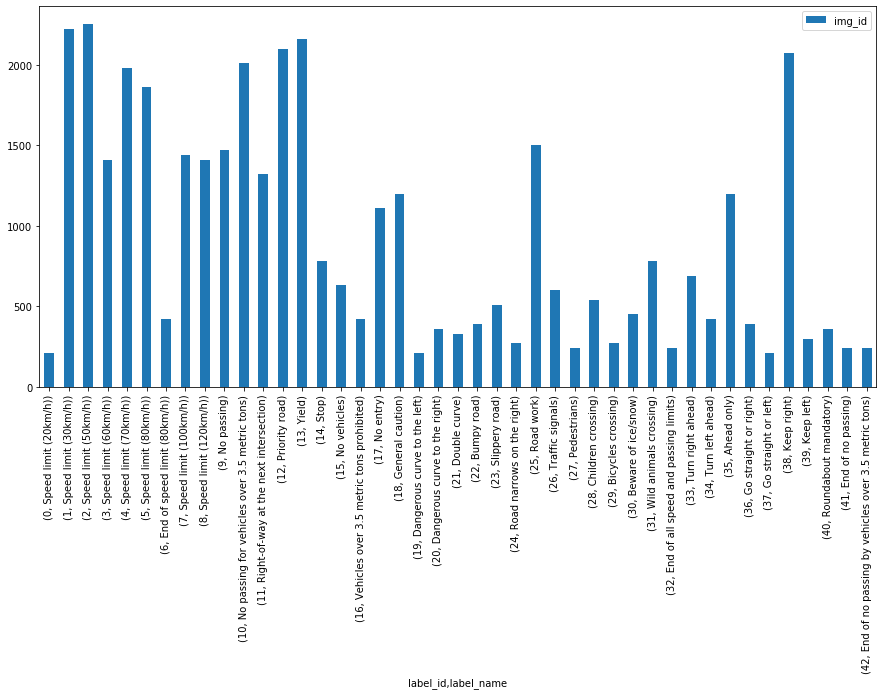

In [81]:
# 对每一个类中的图像进行数据统计并绘制对应的直方图
X_train_group_by_label_count.plot(kind='bar', figsize=(15,7))

#### 训练集图像可视化

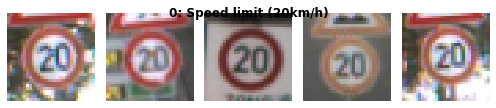

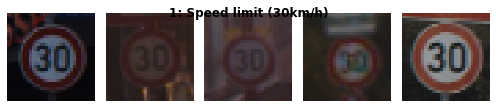

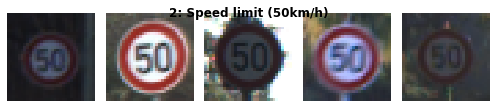

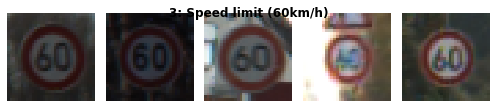

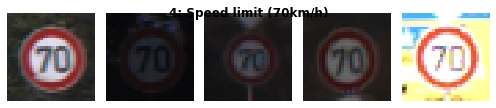

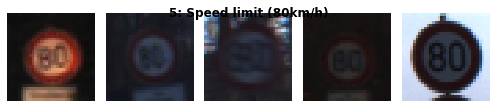

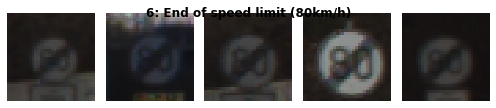

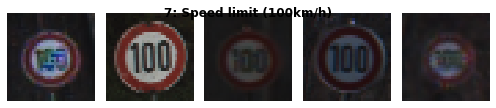

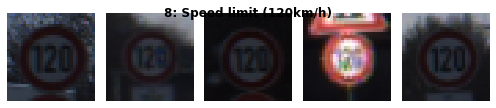

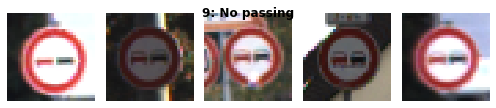

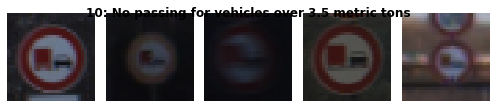

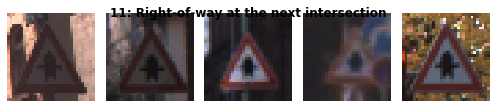

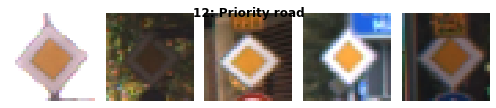

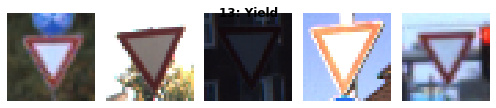

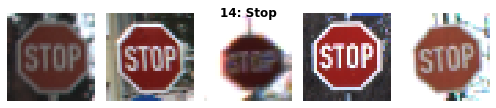

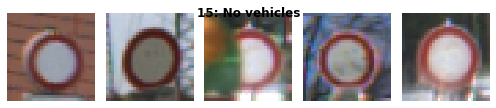

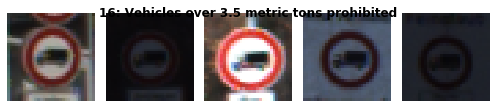

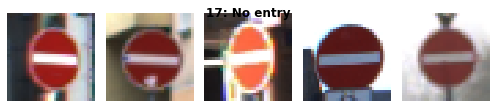

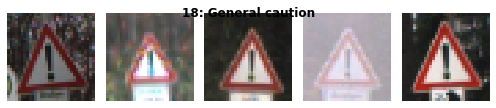

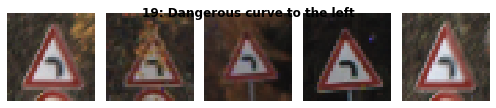

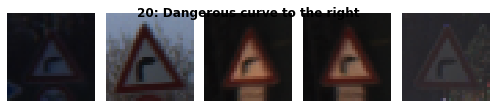

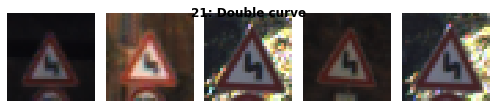

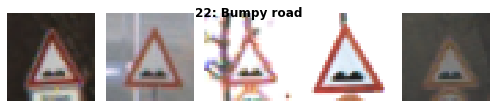

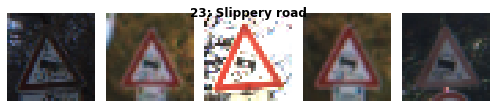

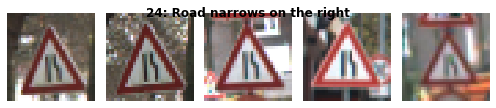

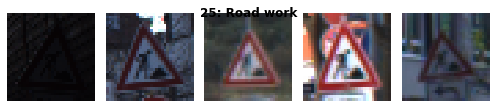

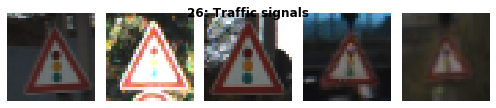

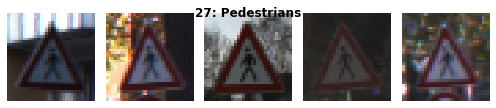

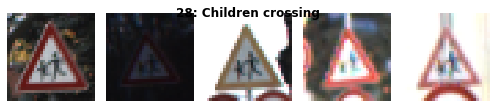

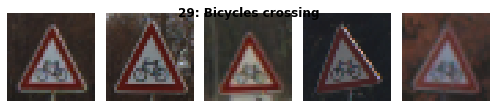

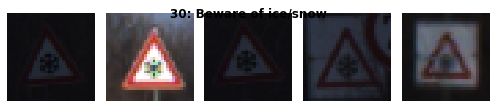

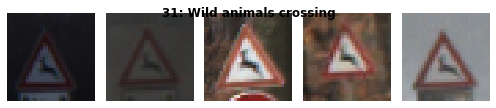

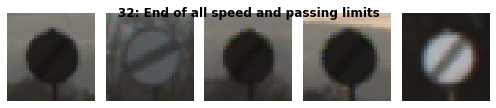

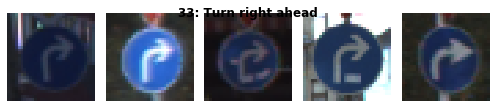

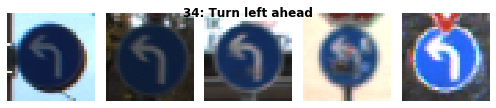

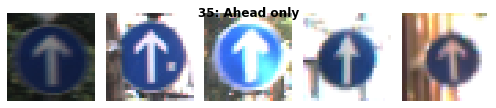

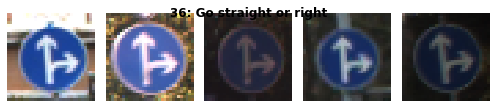

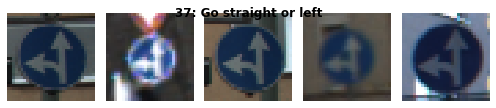

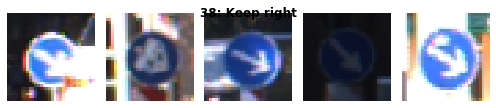

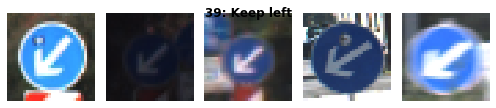

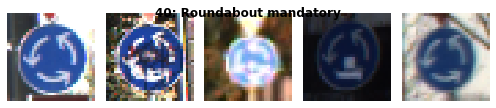

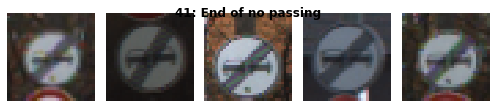

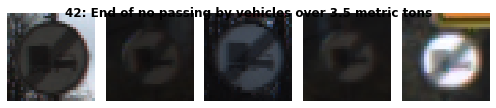

In [10]:
# 从每一类中随机选取5张图像
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 5

show_random_dataset_images(X_train_group_by_label, X_train)

训练集中有超过3万张图像，在整个数据集上尝试每个模型会非常耗费时间，因此，我们创建一个用于训练模型的合适、稍小一些的样本数据集，这个样本数据集按照原数据集的样本百分比p进行创建。

#### 创建样本数据集

In [11]:
X_sample_train, y_sample_train = create_sample_set(X_train_group_by_label, X_train, y_train, pct=0.33)
print("样本训练集图像矩阵的维度={0}, 标签矩阵的维度={1}".format(X_sample_train.shape, y_sample_train.shape))

样本训练集图像矩阵的维度=(12923, 32, 32, 3), 标签矩阵的维度=(12923,)


从上面给出的训练集的数据中我们可以看到，有一些图像非常黑，因此，我们应该对这些图像进行合适的预处理以增强其亮度。

----

## 二、 模型结构的设计以及测试

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### 数据预处理

图像数据必须进行归一化，这样可以保证数据的均值为0，并且具有相等的方差。对于图像数据来说，`(pixel - 128)/128`是一个快速归一化数据的方法。

其他的数据预处理步骤是可选的，可以尝试进行不同的处理来观察其是否对结果有所改善

#### 归一化


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


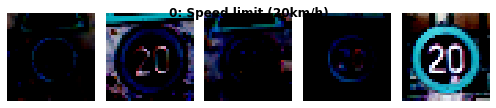

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


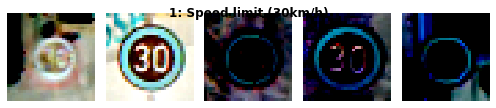

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


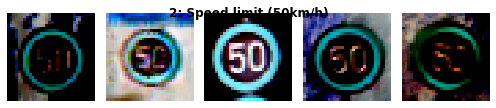

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


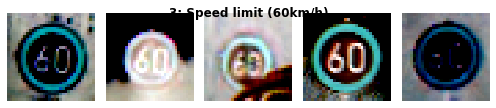

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


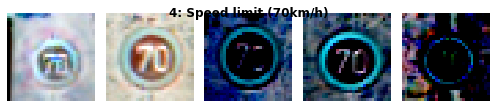

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


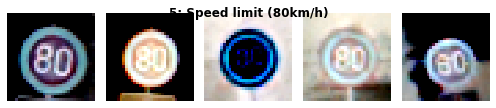

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


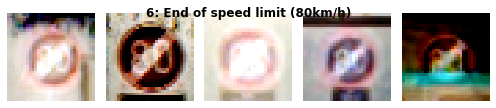

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


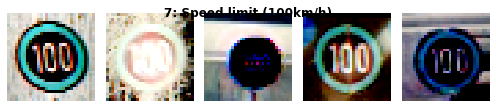

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


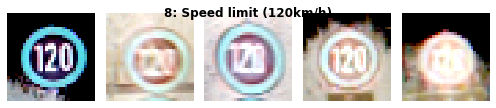

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


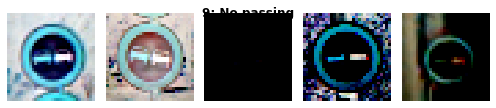

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


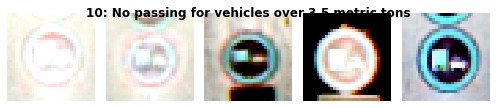

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


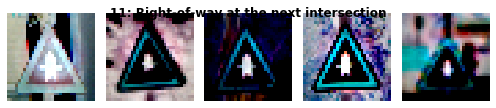

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


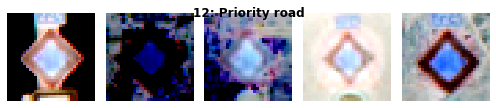

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


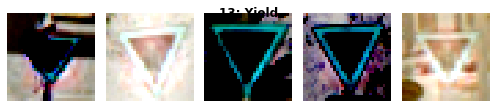

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


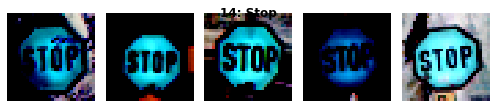

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


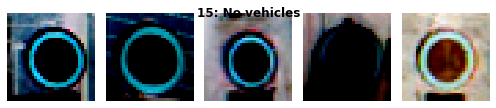

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


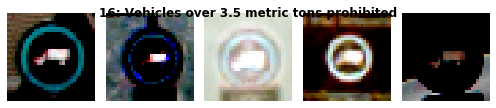

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


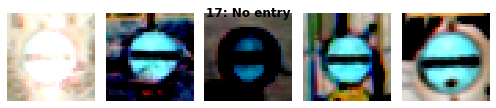

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


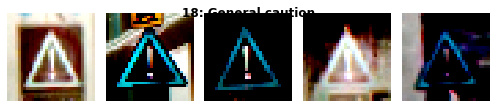

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


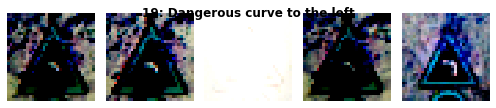

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


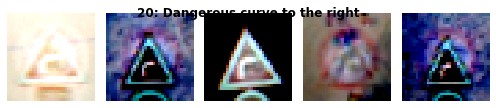

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


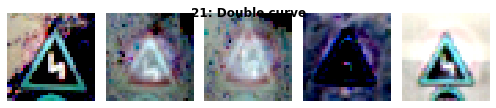

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


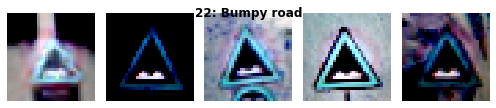

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


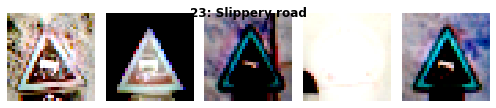

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


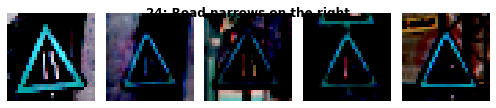

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


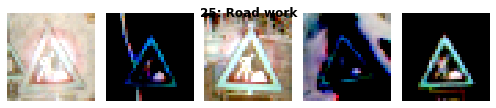

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


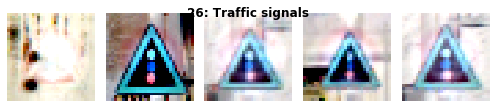

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


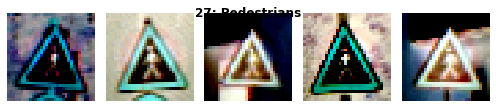

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


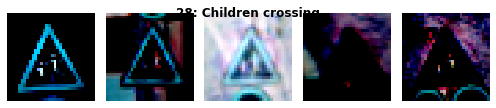

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


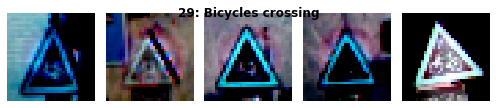

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


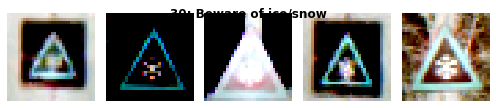

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


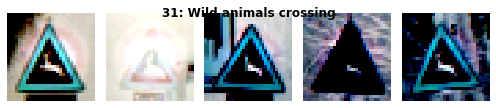

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


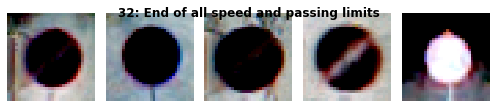

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


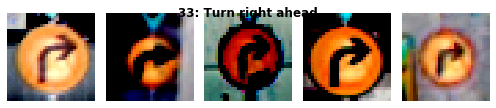

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


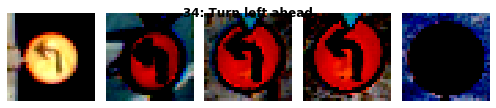

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


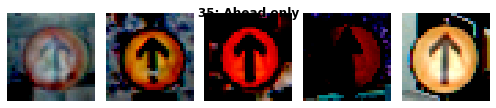

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


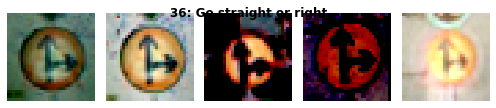

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


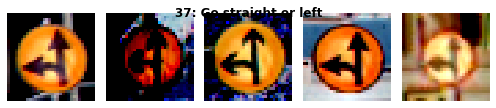

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


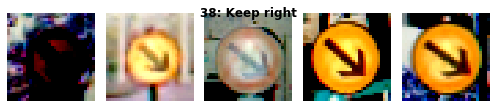

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


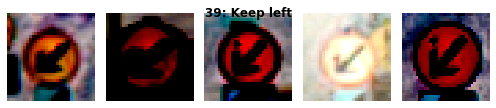

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


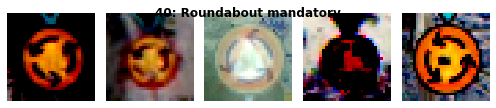

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


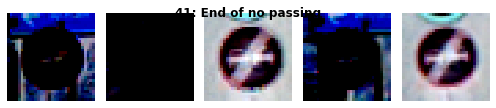

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


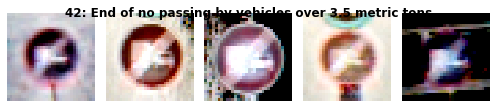

In [36]:
# 归一化训练集数据
X_train_normalised = normalise_images(X_train, X_train)

# 归一化测试集数据，使用训练集的均值和标准差
X_test_normalised = normalise_images(X_test, X_train)
show_random_dataset_images(X_train_group_by_label, X_train_normalised)

#### 灰度图

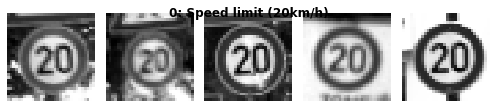

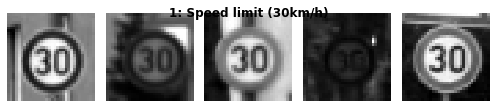

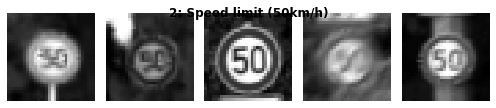

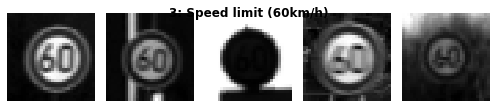

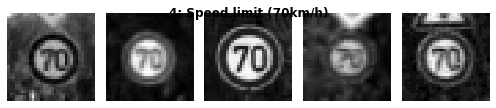

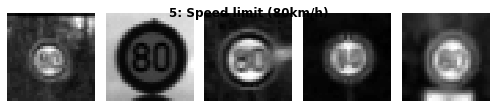

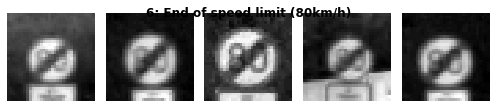

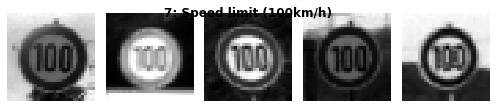

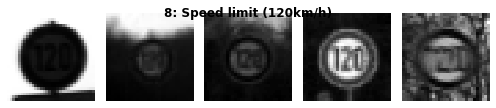

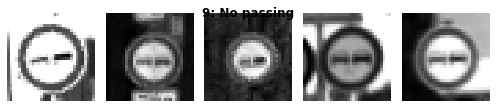

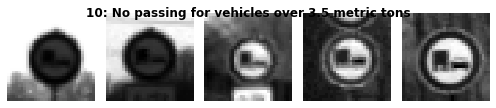

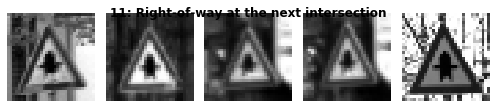

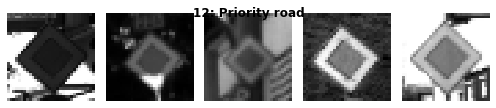

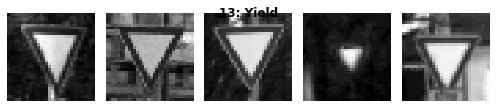

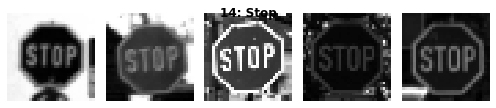

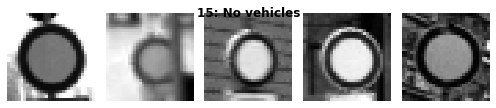

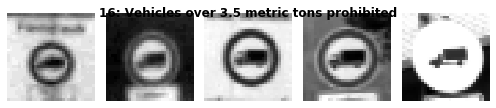

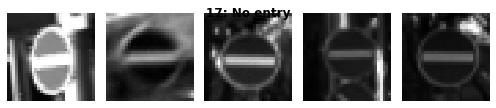

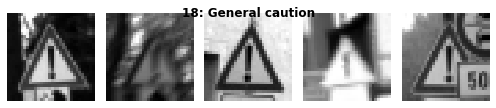

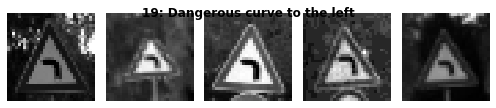

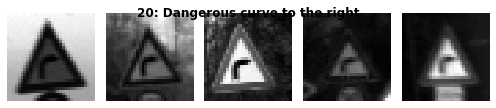

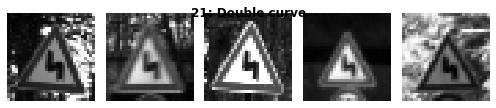

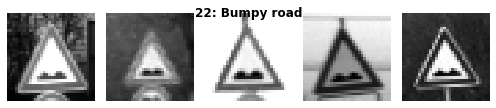

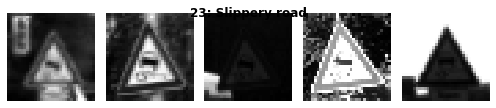

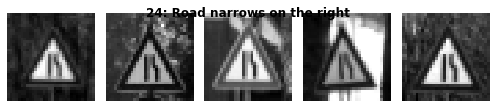

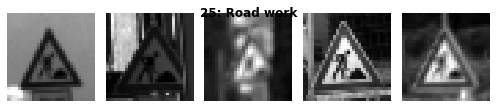

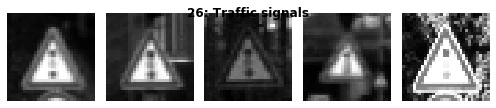

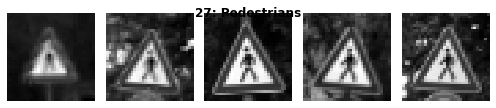

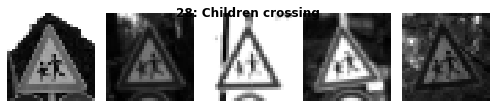

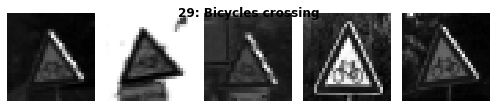

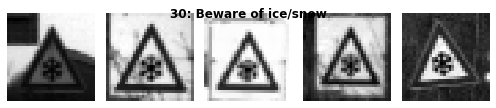

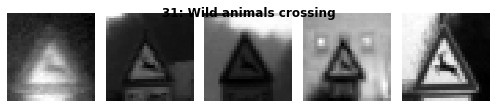

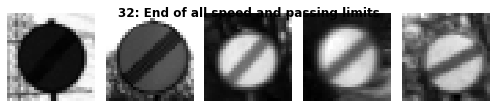

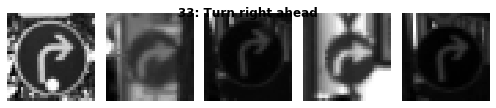

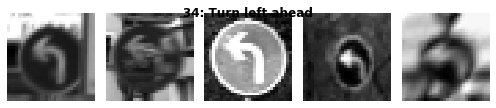

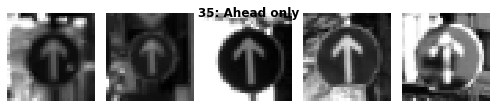

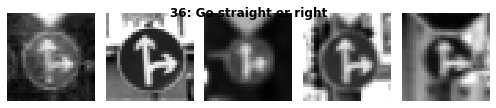

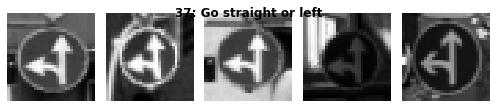

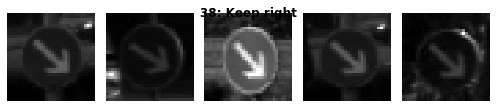

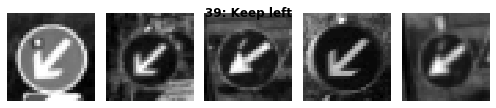

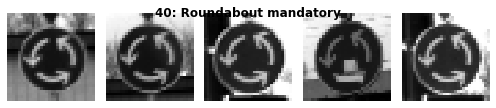

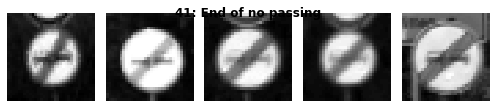

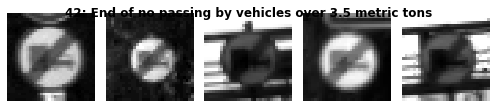

In [13]:
# 将训练集图像转变为灰度图
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train)))
show_random_dataset_images(X_train_group_by_label, X_train_grayscale)

将图像转换为灰度图，在一定程度上增强了图像的清晰度，但是某些图像依旧比较黑

In [14]:
# 将测试集数据转换为灰度图
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test)))

### 模型构建

接下来以LetNet为基础，设计一个可以配置调参的网络。首先从建立pipeline开始。

#### 配置和建立pipeline

In [15]:
class ModelConfig:
    """
    模型配置信息
    """
    def __init__(self, model, name, input_img_dimensions, conv_layers_config, fc_output_dimensions, output_classes, dropout_keep_pct):
        self.model = model
        self.name = name
        self.input_img_dimensions = input_img_dimensions
        
        # 定义过滤器的大小和扩大比例（每层扩大2倍）
        self.conv_filter_size = conv_layers_config[0]
        self.conv_depth_start = conv_layers_config[1]
        # 模型中卷积层数目
        self.conv_layers_count = conv_layers_config[2]
        
        # 全连接层输出维度
        self.fc_output_dims = fc_output_dimensions
        self.output_classes = output_classes
        
        # 在卷积层和全连接层尝试不同的drop out值
        self.dropout_conv_keep_pct = dropout_keep_pct[0]
        self.dropout_fc_keep_pct = dropout_keep_pct[1]

In [16]:
class ModelExecutor:
    """
    模型执行函数
    """
    def __init__(self, model_config, learning_rate=0.001):
        self.model_config = model_config
        self.learning_rate = learning_rate
    
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope( self.model_config.name ) as scope:
                # 创建模型操作函数
                self.create_model_operations()

                # 创建saver保存模型执行的结果
                self.saver = tf.train.Saver()
    
    def create_placeholders(self):
        """
        定义传入值变量:
            - x, y
            - one_hot_y
            - dropout placeholders
        """

        # 我们的例子中图像的维度均为32 * 32 * 3
        input_dims = self.model_config.input_img_dimensions
        self.x = tf.placeholder(tf.float32, (None, input_dims[0], input_dims[1], input_dims[2]), name="{0}_x".format(self.model_config.name))
        self.y = tf.placeholder(tf.int32, (None), name="{0}_y".format(self.model_config.name))
        # 将输出的类转换为独热编码
        self.one_hot_y = tf.one_hot(self.y, self.model_config.output_classes)

        self.dropout_placeholder_conv = tf.placeholder(tf.float32)
        self.dropout_placeholder_fc = tf.placeholder(tf.float32)

    
    def create_model_operations(self):
        """
        定义深度学习训练pipeline时所需要的函数操作
        """

        # 创建变量
        self.create_placeholders()

        cnn = self.model_config.model

        # 创建网络 
        self.logits = cnn(self.x, self.model_config, self.dropout_placeholder_conv, self.dropout_placeholder_fc)
        
        # 使用softmax函数作为最后一层的激活函数
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        
        # 将所有批次的损失合在一起
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        
        # 使用AdamOptimizer优化器控制学习速度
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        
        # 通过选择的优化器来减小损失
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # 根据标签获取模型的最佳预测并检查它们是否匹配
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        
        # 在批级上判断准确度
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # 在没有给定标签的情况下预测图像的种类
        self.prediction = tf.argmax(self.logits, 1)
        
        # 记录前5个预测
        self.top5_predictions = tf.nn.top_k(tf.nn.softmax(self.logits), k=5, sorted=True, name=None)

        
    def evaluate_model(self, X_data, Y_data, batch_size):
        """
        计算模型在给定数据集上的准确度和损失
        在本例中dropout值被忽略 (dropout_keep_pct = 1.0)
        """
        
        num_examples = len(X_data)
        total_accuracy = 0.0
        total_loss = 0.0
        sess = tf.get_default_session()

        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            
            # 计算该批的准确度和损失
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })
            loss = sess.run(self.loss_operation, feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })

            # 根据该批图像数量计算该批的准确度的权重
            total_accuracy += (accuracy * len(batch_x))        
            total_loss += (loss * len(batch_x))            

        # 计算整个数据集上的平均准确度
        return (total_accuracy / num_examples, total_loss / num_examples) 
    
    
    def train_model(self, X_train_features, X_train_labels, batch_size=512, epochs=100, PRINT_FREQ=10):
        """
        训练模型
        """

        training_metrics = np.zeros((epochs, 3))

        with tf.Session(graph = self.graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:            
            
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_features)


            print("Training {0} [epochs={1}, batch_size={2}]...\n".format(self.model_config.name, epochs, batch_size))

            for i in range(epochs):
                start = time.time()
                X_train, Y_train = shuffle(X_train_features, X_train_labels)
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={
                        self.x: batch_x, 
                        self.y: batch_y, 
                        self.dropout_placeholder_conv: self.model_config.dropout_conv_keep_pct,
                        self.dropout_placeholder_fc: self.model_config.dropout_fc_keep_pct,

                    })

                end_training_time = time.time()
                training_duration = end_training_time - start

                # 计算训练准确度
                training_accuracy, training_loss = self.evaluate_model(X_train_features, X_train_labels, batch_size)            

                end_epoch_time = time.time()             
                epoch_duration = end_epoch_time - start

                if i == 0 or (i+1) % PRINT_FREQ == 0:
                    print("[{0}]\ttotal={1:.3f}s | train: time={2:.3f}s, 损失率={3:.4f}, 准确度={4:.4f} ".format(
                          i+1, epoch_duration, training_duration, training_loss, training_accuracy))

                training_metrics[i] = [training_duration, training_loss, training_accuracy]

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            # 保存模型
            self.saver.save(sess, model_file_name)
            print("模型 {0} 已保存".format(model_file_name))

        return (training_metrics, epoch_duration)
    
    def test_model(self, test_imgs, test_lbs, batch_size=512):
        """
        在测试集上测试模型
        返回元组 (测试集准确度, 测试集损失, 测试时间)
        """

        with tf.Session(graph = self.graph) as sess:
            # 初始化变量
            tf.global_variables_initializer()

            
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)

            start = time.time()
            (test_accuracy, test_loss) = self.evaluate_model(test_imgs, test_lbs, batch_size)
            duration = time.time() - start
            print("[{0} - Test Set]\ttime={1:.3f}s, 损失率={2:.4f}, 准确度={3:.4f}".format(self.model_config.name, duration, test_loss, test_accuracy))

        
        return (test_accuracy, test_loss, duration)
    
    def predict(self, imgs, top_5=False):
        """
        给一些数据进行预测
        """
        preds = None
        with tf.Session(graph = self.graph) as sess:
            # 初始化变量
            tf.global_variables_initializer()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            if top_5:
                preds = sess.run(self.top5_predictions, feed_dict={
                        self.x: imgs,
                        self.dropout_placeholder_conv: 1.0,
                        self.dropout_placeholder_fc: 1.0
                    })
            else:
                preds = sess.run(self.prediction, feed_dict={
                    self.x: imgs,
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
    
        return preds
    
    def show_conv_feature_maps(self, img, conv_layer_idx=0, activation_min=-1, activation_max=-1 ,
                               plt_num=1, fig_size=(15, 15), title_y_pos=1.0):
        """
        在给定的卷积级别上显示单个图像的结果特征图
        """
        #s = tf.train.Saver()
        with tf.Session(graph = self.graph) as sess:
            # 初始化变量
            tf.global_variables_initializer()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            # 预测
            preds = sess.run(self.prediction, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })

            
            var_name = "{0}/conv_{1}_relu:0".format(self.model_config.name, conv_layer_idx)
            print("Fetching tensor: {0}".format(var_name))
            conv_layer = tf.get_default_graph().get_tensor_by_name(var_name)
            
            activation = sess.run(conv_layer, feed_dict={
                            self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                            self.dropout_placeholder_conv: 1.0,
                            self.dropout_placeholder_fc: 1.0
                            })
            featuremaps = activation.shape[-1]
            # (1, 13, 13, 64)
            print("激活层维度: {0}".format(activation.shape))
            
            #fix the number of columns
            cols = 8
            rows = featuremaps // cols
            fig, axes = plt.subplots(rows, cols, figsize=fig_size)
            k = 0
            for i in range(0, rows):
                for j in range(0, cols):
                    ax = axes[i, j]
                    featuremap = k

                    if activation_min != -1 & activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
                    elif activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
                    elif activation_min !=-1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
                    else:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
                    
                    ax.axis("off")
                    k += 1
            
            fig.suptitle("层: {0}的特征图".format(conv_layer), fontsize=12, fontweight='bold', y=title_y_pos)
            fig.tight_layout()
            plt.show()

#### 定义模型 

基于Yann Le Cun的LeNet网络结构，本例中可以修改其网络配置及变量

In [17]:
from tensorflow.contrib.layers import flatten

def EditLeNet(x, mc, dropout_conv_pct, dropout_fc_pct):
    """
    mc: 包含模型的配置信息、 不同卷积层过滤器的大小 、全连接层的数目和它们的输出维度
    dropout_conv_pct: 卷积层的dropout参数
    dropout_fc_pct: 全连接层的dropout参数
    """
    
    # 随机定义权重和偏差
    mu = 0
    sigma = 0.1
    
    prev_conv_layer = x
    conv_depth = mc.conv_depth_start
    conv_input_depth = mc.input_img_dimensions[-1]
   
    print("[EditLeNet] 正在建立网络结构 [卷积层数目={0}, 卷积层过滤器大小={1}, 卷积层初始深度={2}, 全连接层数目={3}]".format(
        mc.conv_layers_count, mc.conv_filter_size, conv_depth, len(mc.fc_output_dims)))
    
    for i in range(0, mc.conv_layers_count):
        # 层深指数增长
        conv_output_depth = conv_depth * (2 ** (i))
        conv_W = tf.Variable(tf.truncated_normal(shape=(mc.conv_filter_size, mc.conv_filter_size, conv_input_depth, conv_output_depth), 
                                              mean = mu, stddev = sigma))
        conv_b = tf.Variable(tf.zeros(conv_output_depth))
        
        conv_output = tf.nn.conv2d(prev_conv_layer, conv_W, strides=[1, 1, 1, 1], padding='VALID', name="conv_{0}".format(i)) + conv_b
        conv_output = tf.nn.relu(conv_output, name="conv_{0}_relu".format(i))
        # 2x2最大值池化操作
        conv_output = tf.nn.max_pool(conv_output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        # 在卷积层时便使用dropout策略
        conv_output = tf.nn.dropout(conv_output, dropout_conv_pct) 
        
        # 设置循环变量
        prev_conv_layer = conv_output
        conv_input_depth = conv_output_depth

    
    # flatten第二层卷积层的结果使其能够输入到全连接层
    fc0   = flatten(prev_conv_layer)
    
    # 创建全连接层
    prev_layer = fc0
    for output_dim in mc.fc_output_dims:
        fcn_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], output_dim), 
                                                 mean = mu, stddev = sigma))
        fcn_b  = tf.Variable(tf.zeros(output_dim))
        
        prev_layer   = tf.nn.dropout(tf.nn.relu(tf.matmul(prev_layer, fcn_W) + fcn_b), dropout_fc_pct)

    
    # 最后一层仍为全连接层
    fc_final_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], mc.output_classes), 
                                                  mean = mu, stddev = sigma))
    fc_final_b  = tf.Variable(tf.zeros(mc.output_classes))
    logits = tf.matmul(prev_layer, fc_final_W) + fc_final_b
    
    return logits

### 训练并测试模型

#### 未归一化的数据集 

我们首先使用未归一化的数据集对模型进行训练以及测试

#### 1.彩色图像

In [39]:
X_sample_train, y_sample_train = create_sample_set(X_train_group_by_label, X_train, y_train, pct=0.33)

In [40]:
# 模型配置
mc_3x3 = ModelConfig(EditLeNet, "EditLeNet_3x3_Color", [32, 32, 3], [3, 16, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EditLeNet, "EditLeNet_5x5_Color", [32, 32, 3], [5, 16, 2], [120, 84], n_classes, [1.0, 1.0])
mc_7x7 = ModelConfig(EditLeNet, "EditLeNet_7x7_Color", [32, 32, 3], [7, 16, 2], [120, 84], n_classes, [1.0, 1.0])

In [41]:
# 创建模型
me_color_3x3 = ModelExecutor(mc_3x3)
me_color_5x5 = ModelExecutor(mc_5x5)
me_color_7x7 = ModelExecutor(mc_7x7)

[EditLeNet] 正在建立网络结构 [卷积层数目=3, 卷积层过滤器大小=3, 卷积层初始深度=16, 全连接层数目=2]
[EditLeNet] 正在建立网络结构 [卷积层数目=2, 卷积层过滤器大小=5, 卷积层初始深度=16, 全连接层数目=2]
[EditLeNet] 正在建立网络结构 [卷积层数目=2, 卷积层过滤器大小=7, 卷积层初始深度=16, 全连接层数目=2]


In [42]:
(c_3x3_tr_metrics, c_3x3_duration) = me_color_3x3.train_model(X_sample_train, y_sample_train, epochs=50)
(c_3x3_ts_accuracy, c_3x3_ts_loss, c_3x3_ts_duration) =  me_color_3x3.test_model(X_test, y_test)

Training EditLeNet_3x3_Color [epochs=50, batch_size=512]...

[1]	total=14.252s | train: time=8.116s, 损失率=3.3179, 准确度=0.1802 
[10]	total=13.847s | train: time=7.844s, 损失率=0.3427, 准确度=0.9081 
[20]	total=13.894s | train: time=7.896s, 损失率=0.0590, 准确度=0.9889 
[30]	total=13.927s | train: time=7.919s, 损失率=0.0121, 准确度=0.9995 
[40]	total=13.928s | train: time=7.964s, 损失率=0.0581, 准确度=0.9827 
[50]	total=14.428s | train: time=8.256s, 损失率=0.0156, 准确度=0.9967 
模型 ./models/EditLeNet_3x3_Color.chkpt 已保存
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_3x3_Color.chkpt
[EditLeNet_3x3_Color - Test Set]	time=6.258s, 损失率=1.2819, 准确度=0.8555


In [44]:
(c_5x5_tr_metrics, c_5x5_duration) = me_color_5x5.train_model(X_sample_train, y_sample_train, epochs=50)
(c_5x5_ts_accuracy, c_5x5_ts_loss, c_5x5_ts_duration) =  me_color_5x5.test_model(X_test, y_test)

Training EditLeNet_5x5_Color [epochs=50, batch_size=512]...

[1]	total=14.269s | train: time=8.336s, 损失率=3.6936, 准确度=0.1204 
[10]	total=13.886s | train: time=8.055s, 损失率=0.4657, 准确度=0.8671 
[20]	total=13.952s | train: time=8.111s, 损失率=0.0577, 准确度=0.9888 
[30]	total=14.748s | train: time=8.813s, 损失率=0.0110, 准确度=0.9999 
[40]	total=14.393s | train: time=8.129s, 损失率=0.0035, 准确度=1.0000 
[50]	total=13.938s | train: time=8.110s, 损失率=0.0018, 准确度=1.0000 
模型 ./models/EditLeNet_5x5_Color.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_5x5_Color.chkpt
[EditLeNet_5x5_Color - Test Set]	time=6.018s, 损失率=2.3641, 准确度=0.8281


In [45]:
(c_7x7_tr_metrics, c_7x7_duration) = me_color_7x7.train_model(X_sample_train, y_sample_train, epochs=50)
(c_7x7_ts_accuracy, c_7x7_ts_loss, c_7x7_ts_duration) =  me_color_7x7.test_model(X_test, y_test)

Training EditLeNet_7x7_Color [epochs=50, batch_size=512]...

[1]	total=14.146s | train: time=8.507s, 损失率=4.4763, 准确度=0.1260 
[10]	total=13.853s | train: time=8.348s, 损失率=0.8772, 准确度=0.7583 
[20]	total=13.806s | train: time=8.293s, 损失率=0.2241, 准确度=0.9377 
[30]	total=13.805s | train: time=8.302s, 损失率=0.0847, 准确度=0.9803 
[40]	total=13.967s | train: time=8.451s, 损失率=0.0362, 准确度=0.9914 
[50]	total=14.181s | train: time=8.617s, 损失率=0.0177, 准确度=0.9970 
模型 ./models/EditLeNet_7x7_Color.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_7x7_Color.chkpt
[EditLeNet_7x7_Color - Test Set]	time=5.647s, 损失率=1.8258, 准确度=0.8276


Length of axis: (2,)


c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 33394 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27169 missing from current font.
  font.

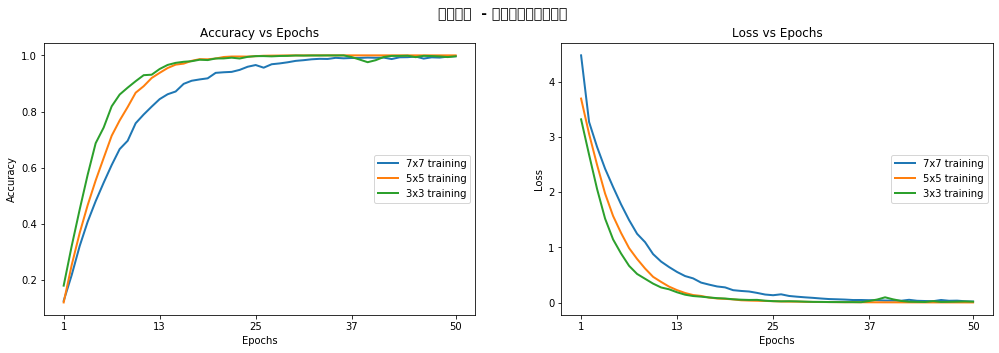

In [46]:
metrics_arr = [c_7x7_tr_metrics,  c_5x5_tr_metrics, c_3x3_tr_metrics]
lbs = ["7x7 training",  "5x5 training",  "3x3 training"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                    "彩色图像  - 模型准确度和损失率"
                    , fig_size=(17, 5))

#### 2.灰度图像

In [87]:
X_sample_train_grayscale, y_sample_train = create_sample_set(X_train_group_by_label, X_train_grayscale, y_train, pct=0.33)

In [96]:
# 将输入数据reshape为tensorflow接受的数据格式 (例如， 4维张量)
X_sample_train_grayscale = np.reshape(X_sample_train_grayscale, (X_sample_train_grayscale.shape[0], 32, 32, 1))
X_test_grayscale = np.reshape(X_test_grayscale, (X_test_grayscale.shape[0], 32, 32, 1))

In [97]:
mc_3x3 = ModelConfig(EditLeNet, "EditNet_Grayscale_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EditLeNet, "EditNet_Grayscale_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [98]:
me_gray_3x3 = ModelExecutor(mc_3x3)
me_gray_5x5 = ModelExecutor(mc_5x5)

[EditLeNet] 正在建立网络结构 [卷积层数目=3, 卷积层过滤器大小=3, 卷积层初始深度=32, 全连接层数目=2]
[EditLeNet] 正在建立网络结构 [卷积层数目=2, 卷积层过滤器大小=5, 卷积层初始深度=32, 全连接层数目=2]


In [99]:
(g_3x3_tr_metrics, g_3x3_duration) = me_gray_3x3.train_model(X_sample_train_grayscale, y_sample_train, epochs=50)
(g_3x3_ts_accuracy, g_3x3_ts_loss, g_3x3_ts_duration) =  me_gray_3x3.test_model(X_test_grayscale, y_test)

Training EditNet_Grayscale_3x3 [epochs=50, batch_size=512]...

[1]	total=17.256s | train: time=10.548s, 损失率=3.6840, 准确度=0.0703 
[10]	total=18.068s | train: time=11.263s, 损失率=0.4445, 准确度=0.8837 
[20]	total=17.574s | train: time=10.217s, 损失率=0.0653, 准确度=0.9879 
[30]	total=21.345s | train: time=13.123s, 损失率=0.0149, 准确度=0.9989 
[40]	total=16.474s | train: time=10.069s, 损失率=0.0656, 准确度=0.9830 
[50]	total=16.709s | train: time=10.039s, 损失率=0.0226, 准确度=0.9956 
模型 ./models/EditNet_Grayscale_3x3.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditNet_Grayscale_3x3.chkpt
[EditNet_Grayscale_3x3 - Test Set]	time=7.061s, 损失率=1.2590, 准确度=0.8596


In [100]:
(g_5x5_tr_metrics, g_5x5_duration) = me_gray_5x5.train_model(X_sample_train_grayscale, y_sample_train, epochs=50)
(g_5x5_ts_accuracy, g_5x5_ts_loss, g_5x5_ts_duration) =  me_gray_5x5.test_model(X_test_grayscale, y_test)

Training EditNet_Grayscale_5x5 [epochs=50, batch_size=512]...

[1]	total=16.123s | train: time=9.989s, 损失率=5.6397, 准确度=0.1143 
[10]	total=15.961s | train: time=9.903s, 损失率=0.4390, 准确度=0.8804 
[20]	total=16.285s | train: time=10.330s, 损失率=0.0591, 准确度=0.9894 
[30]	total=15.351s | train: time=9.451s, 损失率=0.0148, 准确度=0.9988 
[40]	total=15.553s | train: time=9.593s, 损失率=0.0070, 准确度=0.9998 
[50]	total=16.300s | train: time=9.870s, 损失率=0.0020, 准确度=0.9999 
模型 ./models/EditNet_Grayscale_5x5.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditNet_Grayscale_5x5.chkpt
[EditNet_Grayscale_5x5 - Test Set]	time=6.154s, 损失率=2.0089, 准确度=0.8366


Length of axis: (2,)


c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22411 missing from current font.
  font.

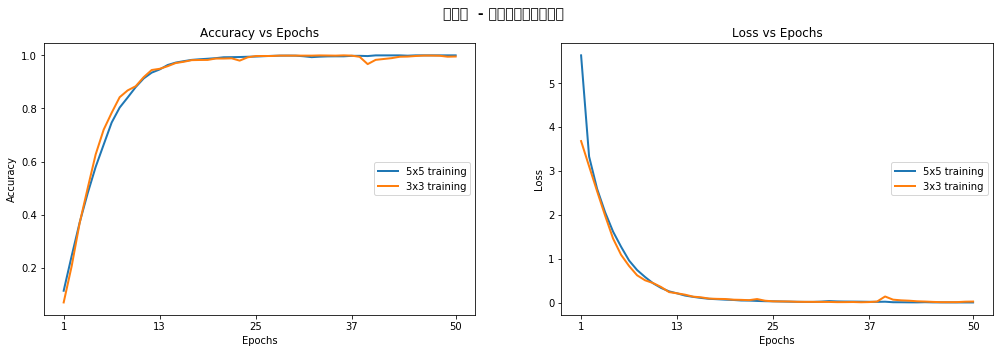

In [101]:
metrics_arr = [g_5x5_tr_metrics,g_3x3_tr_metrics]
lbs = ["5x5 training", "3x3 training"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "灰度图  - 模型准确度和损失率"
                    , fig_size=(17, 5))

### 归一化的数据集

#### 1.彩色图像

In [102]:
X_sample_train_normalised, y_sample_train = create_sample_set(X_train_group_by_label, X_train_normalised, y_train, pct=0.33)

In [103]:
mc_3x3 = ModelConfig(EditLeNet, "EditLeNet_Color_Norm_3x3", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EditLeNet, "EditLeNet_Color_Norm_5x5", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [104]:
me_color_norm_3x3 = ModelExecutor(mc_3x3)
me_color_norm_5x5 = ModelExecutor(mc_5x5)

[EditLeNet] 正在建立网络结构 [卷积层数目=3, 卷积层过滤器大小=3, 卷积层初始深度=32, 全连接层数目=2]
[EditLeNet] 正在建立网络结构 [卷积层数目=2, 卷积层过滤器大小=5, 卷积层初始深度=32, 全连接层数目=2]


In [105]:
(c_norm_3x3_tr_metrics, c_norm_3x3_duration) = me_color_norm_3x3.train_model(X_sample_train_normalised, y_sample_train, epochs=50)
(c_norm_3x3_ts_accuracy, c_norm_3x3_ts_loss, c_norm_3x3_ts_duration) =  me_color_norm_3x3.test_model(X_test_normalised, y_test)

Training EditLeNet_Color_Norm_3x3 [epochs=50, batch_size=512]...

[1]	total=17.791s | train: time=10.637s, 损失率=2.7407, 准确度=0.3322 
[10]	total=18.114s | train: time=10.904s, 损失率=0.1817, 准确度=0.9507 
[20]	total=18.678s | train: time=11.282s, 损失率=0.0311, 准确度=0.9961 
[30]	total=17.691s | train: time=10.596s, 损失率=0.0125, 准确度=0.9975 
[40]	total=17.747s | train: time=10.768s, 损失率=0.0408, 准确度=0.9877 
[50]	total=17.825s | train: time=10.730s, 损失率=0.0017, 准确度=1.0000 
模型 ./models/EditLeNet_Color_Norm_3x3.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_Color_Norm_3x3.chkpt
[EditLeNet_Color_Norm_3x3 - Test Set]	time=7.126s, 损失率=0.7441, 准确度=0.8884


In [107]:
(c_norm_5x5_tr_metrics, c_norm_5x5_duration) = me_color_norm_5x5.train_model(X_sample_train_normalised, y_sample_train, epochs=50)
(c_norm_5x5_ts_accuracy, c_norm_5x5_ts_loss, c_norm_5x5_ts_duration) =  me_color_norm_5x5.test_model(X_test_normalised, y_test)

Training EditLeNet_Color_Norm_5x5 [epochs=50, batch_size=512]...

[1]	total=15.937s | train: time=10.513s, 损失率=2.2261, 准确度=0.4307 
[10]	total=25.895s | train: time=15.602s, 损失率=0.0798, 准确度=0.9835 
[20]	total=25.297s | train: time=15.196s, 损失率=0.0183, 准确度=0.9976 
[30]	total=24.996s | train: time=14.967s, 损失率=0.0216, 准确度=0.9949 
[40]	total=24.956s | train: time=14.920s, 损失率=0.0018, 准确度=0.9999 
[50]	total=25.528s | train: time=15.425s, 损失率=0.0010, 准确度=1.0000 
模型 ./models/EditLeNet_Color_Norm_5x5.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_Color_Norm_5x5.chkpt
[EditLeNet_Color_Norm_5x5 - Test Set]	time=10.401s, 损失率=0.7911, 准确度=0.8970


Length of axis: (2,)


c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 33394 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 65288 missing from current font.
  font.

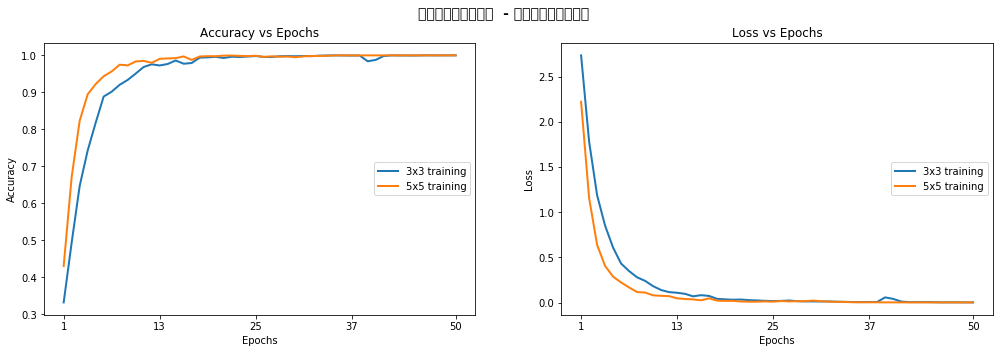

In [108]:
metrics_arr = [c_norm_3x3_tr_metrics, c_norm_5x5_tr_metrics]
lbs = ["3x3 training", "5x5 training"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "彩色图像（归一化）  - 模型准确度和损失率"
                    , fig_size=(17, 5))     

#### 2.灰度图像

In [18]:
# 对灰度图像进行归一化
X_train_grayscale_normalised = normalise_images(X_train_grayscale, X_train_grayscale)
X_test_grayscale_normalised = normalise_images(X_test_grayscale, X_train_grayscale)

In [19]:
X_sample_train_g_nor, y_sample_train = create_sample_set(X_train_group_by_label, X_train_grayscale_normalised, y_train, pct=0.33)

In [20]:
# 将输入数据reshape为tensorflow接受的数据格式 (例如， 4维张量)
X_sample_train_g_nor = np.reshape(X_sample_train_g_nor, (X_sample_train_g_nor.shape[0], 32, 32, 1))
X_test_grayscale_normalised = np.reshape(X_test_grayscale_normalised, (X_test_grayscale_normalised.shape[0], 32, 32, 1))

In [21]:
mc_3x3 = ModelConfig(EditLeNet, "EditLeNet_Grayscale_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EditLeNet, "EditLeNet_Grayscale_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [22]:
me_gray_norm_3x3 = ModelExecutor(mc_3x3)
me_gray_norm_5x5 = ModelExecutor(mc_5x5)

[EditLeNet] 正在建立网络结构 [卷积层数目=3, 卷积层过滤器大小=3, 卷积层初始深度=32, 全连接层数目=2]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[EditLeNet] 正在建立网络结构 [卷积层数目=2, 卷积层过滤器大小=5, 卷积层初始深度=32, 全连接层数目=2]


In [23]:
(g_norm_3x3_tr_metrics, g_norm_3x3_duration) = me_gray_norm_3x3.train_model(X_sample_train_g_nor, y_sample_train, epochs=50)
(g_norm_3x3_ts_accuracy, g_norm_3x3_ts_loss, g_norm_3x3_ts_duration) =  me_gray_norm_3x3.test_model(X_test_grayscale_normalised, y_test)

Training EditLeNet_Grayscale_Norm_3x3 [epochs=50, batch_size=512]...

[1]	total=24.825s | train: time=15.821s, 损失率=3.0048, 准确度=0.2380 
[10]	total=23.569s | train: time=14.899s, 损失率=0.2253, 准确度=0.9424 
[20]	total=20.877s | train: time=12.763s, 损失率=0.0534, 准确度=0.9920 
[30]	total=26.457s | train: time=16.161s, 损失率=0.0134, 准确度=0.9988 
[40]	total=22.522s | train: time=13.717s, 损失率=0.0060, 准确度=0.9997 
[50]	total=20.513s | train: time=12.047s, 损失率=0.0037, 准确度=0.9998 
模型 ./models/EditLeNet_Grayscale_Norm_3x3.chkpt 已保存
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_Grayscale_Norm_3x3.chkpt
[EditLeNet_Grayscale_Norm_3x3 - Test Set]	time=9.465s, 损失率=0.9464, 准确度=0.8812


In [24]:
(g_norm_5x5_tr_metrics, g_norm_5x5_duration) = me_gray_norm_5x5.train_model(X_sample_train_g_nor, y_sample_train, epochs=50)
(g_norm_5x5_ts_accuracy, g_norm_5x5_ts_loss, g_norm_5x5_ts_duration) =  me_gray_norm_5x5.test_model(X_test_grayscale_normalised, y_test)

Training EditLeNet_Grayscale_Norm_5x5 [epochs=50, batch_size=512]...

[1]	total=19.874s | train: time=12.274s, 损失率=2.6310, 准确度=0.3591 
[10]	total=17.714s | train: time=10.861s, 损失率=0.1376, 准确度=0.9664 
[20]	total=20.503s | train: time=12.869s, 损失率=0.0257, 准确度=0.9971 
[30]	total=19.201s | train: time=11.805s, 损失率=0.0088, 准确度=0.9988 
[40]	total=20.379s | train: time=11.845s, 损失率=0.0032, 准确度=1.0000 
[50]	total=16.929s | train: time=10.888s, 损失率=0.0203, 准确度=0.9957 
模型 ./models/EditLeNet_Grayscale_Norm_5x5.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_Grayscale_Norm_5x5.chkpt
[EditLeNet_Grayscale_Norm_5x5 - Test Set]	time=6.238s, 损失率=0.8869, 准确度=0.8838


Length of axis: (2,)


c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24402 missing from current font.
  font.

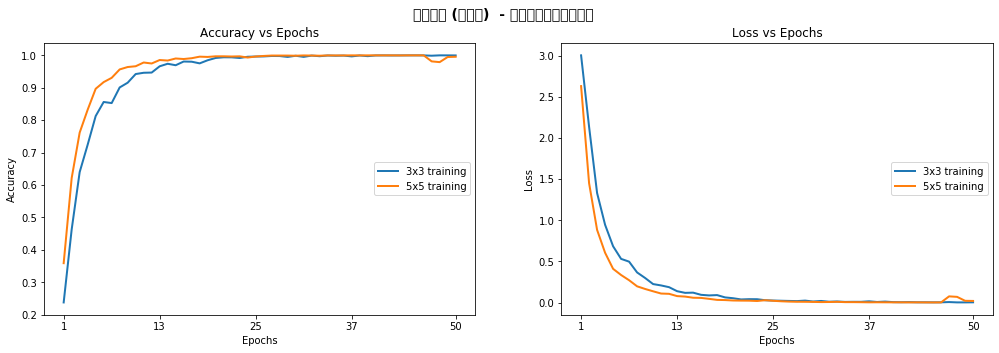

In [25]:
metrics_arr = [g_norm_3x3_tr_metrics, g_norm_5x5_tr_metrics]
lbs = ["3x3 training", "5x5 training"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "灰度图像 (归一化)  - 模型的准确度和损失率"
                    , fig_size=(17, 5))     

---
## 三、网络改进

在这一部分，我们使用Dropout方法对网络进行改进，防止因模型参数过多、训练样本过少而导致过拟合现象的产生。

### Dropout —— 保持全连接层的权重为50%

#### 1.灰度图像

In [26]:
mc_3x3 = ModelConfig(EditLeNet, "EditLeNet_Norm_Grayscale_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(EditLeNet, "EditLeNet_Norm_Grayscale_5x5_Dropout_0.50", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])

In [27]:
me_gray_norm_drpt_50_3x3 = ModelExecutor(mc_3x3)
me_gray_norm_drpt_50_5x5 = ModelExecutor(mc_5x5)

[EditLeNet] 正在建立网络结构 [卷积层数目=3, 卷积层过滤器大小=3, 卷积层初始深度=32, 全连接层数目=2]
[EditLeNet] 正在建立网络结构 [卷积层数目=2, 卷积层过滤器大小=5, 卷积层初始深度=32, 全连接层数目=2]


In [30]:
(g_norm_drpt_50_3x3_tr_metrics, g_norm_drpt_50_3x3_duration) = me_gray_norm_drpt_50_3x3.train_model(X_sample_train_g_nor, y_sample_train, epochs=50)
(g_norm_drpt_50_3x3_ts_accuracy, g_norm_drpt_50_3x3_ts_loss, g_norm_drpt_50_ts_3x3_duration) =  me_gray_norm_drpt_50_3x3.test_model(X_test_grayscale_normalised, y_test)

Training EditLeNet_Norm_Grayscale_3x3_Dropout_0.50 [epochs=50, batch_size=512]...

[1]	total=17.576s | train: time=10.954s, 损失率=3.6481, 准确度=0.0558 
[10]	total=20.231s | train: time=12.391s, 损失率=1.8266, 准确度=0.4725 
[20]	total=22.368s | train: time=13.611s, 损失率=0.6845, 准确度=0.8074 
[30]	total=23.485s | train: time=15.067s, 损失率=0.3328, 准确度=0.9092 
[40]	total=22.241s | train: time=14.307s, 损失率=0.1778, 准确度=0.9521 
[50]	total=23.584s | train: time=14.634s, 损失率=0.1143, 准确度=0.9674 
模型 ./models/EditLeNet_Norm_Grayscale_3x3_Dropout_0.50.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_Norm_Grayscale_3x3_Dropout_0.50.chkpt
[EditLeNet_Norm_Grayscale_3x3_Dropout_0.50 - Test Set]	time=9.094s, 损失率=0.2773, 准确度=0.9198


In [32]:
(g_norm_drpt_50_5x5_tr_metrics,  g_norm_drpt_50_5x5_duration) = me_gray_norm_drpt_50_5x5.train_model(X_sample_train_g_nor, y_sample_train, epochs=50)
(g_norm_drpt_50_5x5_ts_accuracy, g_norm_drpt_50_5x5_ts_loss, g_norm_drpt_50_ts_5x5_duration) =  me_gray_norm_drpt_50_5x5.test_model(X_test_grayscale_normalised, y_test)

Training EditLeNet_Norm_Grayscale_5x5_Dropout_0.50 [epochs=50, batch_size=512]...

[1]	total=15.955s | train: time=10.389s, 损失率=3.6189, 准确度=0.0836 
[10]	total=18.069s | train: time=11.303s, 损失率=1.3536, 准确度=0.6501 
[20]	total=16.978s | train: time=10.217s, 损失率=0.5046, 准确度=0.8847 
[30]	total=17.194s | train: time=10.632s, 损失率=0.2656, 准确度=0.9451 
[40]	total=17.999s | train: time=10.794s, 损失率=0.1399, 准确度=0.9742 
[50]	total=24.219s | train: time=13.988s, 损失率=0.0874, 准确度=0.9837 
模型 ./models/EditLeNet_Norm_Grayscale_5x5_Dropout_0.50.chkpt 已保存
INFO:tensorflow:Restoring parameters from ./models/EditLeNet_Norm_Grayscale_5x5_Dropout_0.50.chkpt
[EditLeNet_Norm_Grayscale_5x5_Dropout_0.50 - Test Set]	time=8.330s, 损失率=0.2500, 准确度=0.9370


Length of axis: (2,)


c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24402 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\i354762\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28784 missing from current font.
  font.

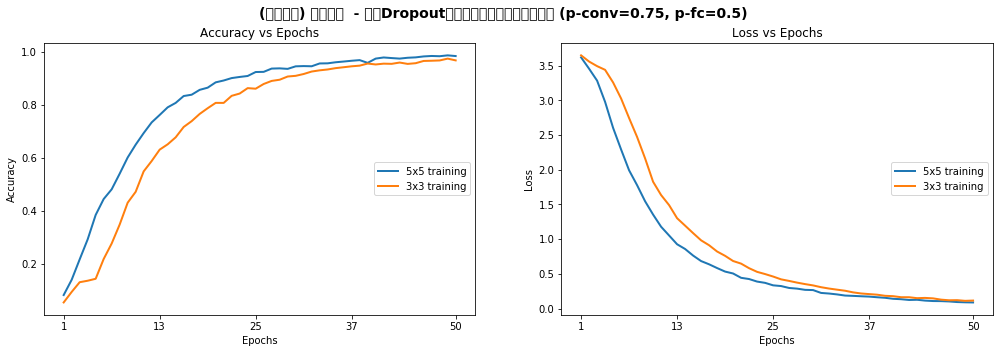

In [33]:
metrics_arr = [g_norm_drpt_50_5x5_tr_metrics, g_norm_drpt_50_3x3_tr_metrics]
lbs = ["5x5 training", "3x3 training"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "(归一化的) 灰度图像  - 使用Dropout方法的模型的准确度和损失率 (p-conv=0.75, p-fc=0.5)"
                    , fig_size=(17, 5))

#### 2.彩色图像

In [ ]:
mc_3x3 = ModelConfig(EditLeNet, "EditLeNet_Norm_3x3_Dropout_0.50", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(EditLeNet, "EditLeNet_Norm_5x5_Dropout_0.50", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])

In [ ]:
me_color_norm_drpt_50_3x3 = ModelExecutor(mc_3x3)
me_color_norm_drpt_50_5x5 = ModelExecutor(mc_5x5)

In [ ]:
(c_norm_drpt_50_3x3_tr_metrics, c_norm_drpt_50_3x3_duration) = me_color_norm_drpt_50_3x3.train_model(X_train_normalised, y_train, epochs=50)
(c_norm_drpt_50_3x3_ts_accuracy, c_norm_drpt_50_3x3_ts_loss, c_norm_drpt_50_ts_3x3_duration) =  me_color_norm_drpt_50_3x3.test_model(X_test_normalised, y_test)

In [ ]:
(c_norm_drpt_50_5x5_tr_metrics,  c_norm_drpt_50_5x5_duration) = me_color_norm_drpt_50_5x5.train_model(X_train_normalised, y_train, epochs=50)
(c_norm_drpt_50_5x5_ts_accuracy, c_norm_drpt_50_5x5_ts_loss, c_norm_drpt_50_ts_5x5_duration) =  me_color_norm_drpt_50_5x5.test_model(X_test_normalised, y_test)

In [ ]:
metrics_arr = [c_norm_drpt_50_5x5_tr_metrics, c_norm_drpt_50_3x3_tr_metrics]
lbs = ["5x5 training", "3x3 training"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "(归一化的) 灰度图像  - 使用Dropout方法的模型的准确度和损失率 (p-conv=0.75, p-fc=0.5)"
                    , fig_size=(17, 5))

---

## 三、 使用新图像测试模型

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### 导入新图像并处理

In [ ]:
from PIL import Image
import os

def get_imgs_from_folder(path, size=(32, 32), grayscale=False):
    """  
    将导入的图像处理为numpy数组
    """
    img_list = [os.path.join(path,f) for f in os.listdir(path) if f.endswith(".jpg") or f.endswith(".png")]
    imgs = None 
    if grayscale:
        imgs = np.empty([len(img_list), size[0], size[1]], dtype=np.uint8) 
    else:
        imgs = np.empty([len(img_list), size[0], size[1], 3], dtype=np.uint8) 

    for i, img_path in enumerate(img_list):
        img = Image.open(img_path).convert('RGB')
        img = img.resize(size)
        im = np.array(to_grayscale(img)) if grayscale else np.array(img)
        imgs[i] = im

    return imgs

In [ ]:
new_imgs_dir = "./custom_images/"
new_imgs = get_imgs_from_folder(new_imgs_dir)
new_imgs.shape

In [ ]:
new_imgs_grayscale = to_grayscale(new_imgs)

In [ ]:
def class_ids_to_labels(cids):
    return list(map(lambda cid: sign_names[sign_names["ClassId"] == cid] ["SignName"].values[0],  cids))

In [ ]:
# 建立新图像的标签数组
new_img_lbs = np.array([8, 12, 15, 25, 16])

In [ ]:
new_img_lbs_text = class_ids_to_labels(new_img_lbs)
new_img_lbs_text

In [ ]:
show_image_list(new_imgs, new_img_lbs_text, "新交通标志彩色图", cols=len(new_imgs), 
                fig_size=(6,6), show_ticks=False)

In [ ]:
show_image_list(new_img_grayscale, new_img_lbs_text, "新交通标志灰度图", cols=len(new_img_grayscale), 
                fig_size=(6,6), show_ticks=False)

### 对每一张图片预测其类别

In [ ]:
# 将新图像归一化
new_img_grayscale_normalised = normalise_images(new_img_grayscale, X_train_grayscale)

# 图像数据转化为tensorflow的数据格式
new_img_grayscale_normalised = np.reshape(new_img_grayscale_normalised, (new_img_grayscale_normalised.shape[0], 32, 32, 1))

In [ ]:
# 预测
preds = me_gray_norm_3x3.predict(new_img_grayscale_normalised)

In [ ]:
preds

### 预测结果分析

#### 准确度计算

In [ ]:
new_img_grayscale_norm_pred_acc = np.sum(new_img_lbs == preds) / len(preds)
print("[归一化灰度图] 在新图像上的预测准确度: {0}%".format(new_img_grayscale_norm_pred_acc * 100))

#### 计算每张图像Top5预测类别的SoftMax概率

In [ ]:
new_img_grayscale_norm_top5_probs =  me_gray_norm_3x3.predict(new_img_grayscale_normalised, top_5=True)


In [ ]:
new_img_grayscale_norm_softmax_lbs_names = list(map(lambda cids: class_ids_to_labels(cids), new_img_grayscale_norm_top5_probs.indices))

In [ ]:
new_img_grayscale_norm_softmax_and_labels = (list(zip(new_img_grayscale_norm_top5_probs.values, new_img_grayscale_norm_softmax_lbs_names)))

#### 2.SoftMax概率数据可视化

In [ ]:
def show_imgs_softmax_probs(imgs, softmax_probs_lb_names, correct_lbs, fig_size=(15, 7)):
    rows = len(imgs)
    fg, ax = plt.subplots(nrows=rows, ncols=2, figsize=fig_size)
    for i, prob_lb in enumerate(softmax_probs_lb_names):
        correct_lb = correct_lbs[i]
        img = imgs[i]
        ax[i,0].imshow(img)
        ax[i,0].axis("off")

        lb_names = prob_lb[1]
        y_pos = np.arange(len(lb_names))
        vals = prob_lb[0]
        for j in range(0, len(lb_names)):
            c = "g" if lb_names[j] == correct_lb else "r"
            ax[i, 1].barh(j, vals[j], color=c, label="{0}".format(lb_names[j]))

        ax[i, 1].set_yticks(y_pos)
        ax[i, 1].set_yticklabels(lb_names)
        ax[i, 1].invert_yaxis()  # labels read top-to-bottom
        ax[i, 1].set_xlabel('Class')
        ax[i, 1].set_title('Softmax')  
        ax[i, 1].set_xscale('log')

        ax[i, 1].legend(loc='lower right')
    
    fg.tight_layout()
    plt.show()

In [ ]:
show_imgs_softmax_probs(new_imgs, new_img_grayscale_norm_softmax_and_labels, new_img_lbs_text, fig_size=(15, 20))

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 
